In [1]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_palette("muted")

# Reordering

In [3]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        col_width,
        median(total) as total,
        median(reorder) as reorder,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results_reorder.csv')
    group by
        category,
        count,
        columns,
        col_width
    order by
        count,
        columns,
        col_width,
        category
""")
reorder_df = con.fetchdf()
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,6.789733e+10
1,row,8.026722e+10


In [4]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.total / r.total + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.total > r.total then c.total / r.total else -(r.total / c.total) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.total > r.total then 1 else -1 end as binary_speedup
    from
        reorder_df r,
        reorder_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
reorder_total_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from reorder_total_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,-1.095455,-1.1


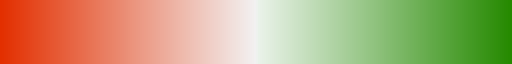

In [5]:
sns.set(font_scale = 1.6)
my_cmap = sns.diverging_palette(15, 125, s=100, l=50, as_cmap=True)
my_cmap

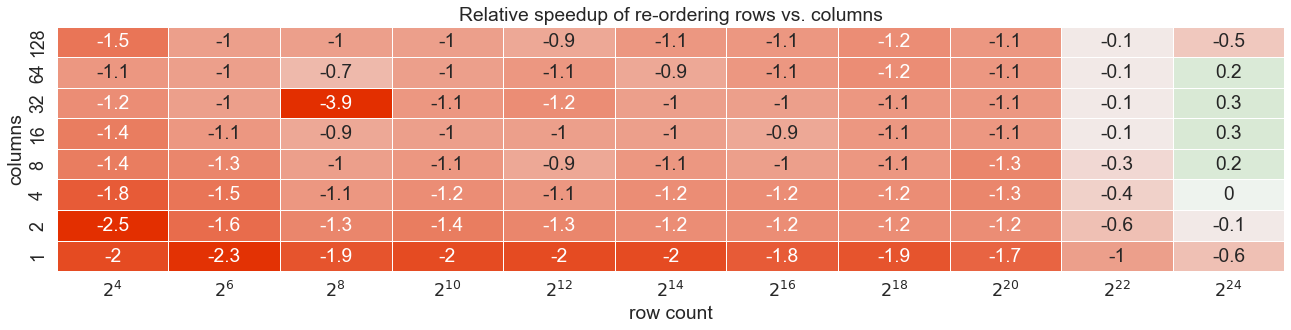

In [6]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(reorder_total_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of payload re-ordering rows vs. columns')
plt.show()

In [7]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.reorder as "row reorder",
        c.reorder as "col reorder",
        cast (case when c.reorder > r.reorder then c.reorder / r.reorder - 0.95 else -(r.reorder / c.reorder - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.reorder / r.reorder + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.reorder > r.reorder then c.reorder / r.reorder else -(r.reorder / c.reorder) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.reorder > r.reorder then 1 else -1 end as binary_speedup
    from
        reorder_df r,
        reorder_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
reorder_only_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from reorder_only_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,8.539773,4.05


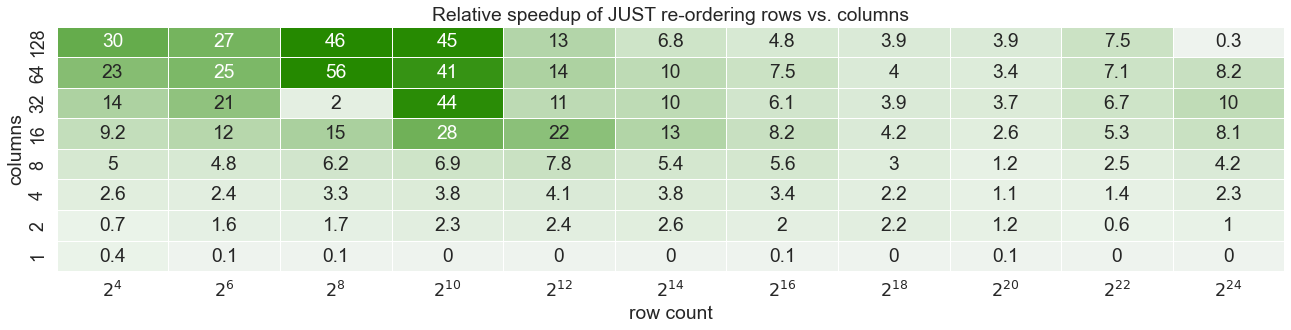

In [8]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(reorder_only_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of JUST re-ordering rows vs. columns (excl. scatter + gather)')
plt.show()

In [9]:
con.execute("""
    select
        cast(log2(count) as int) as "row count",
        columns,
        col_width,
        reorder as "row reorder",
        cast(cast(scatter + gather as double) / total as decimal(10,2)) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        "row count" asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.854773,0.89


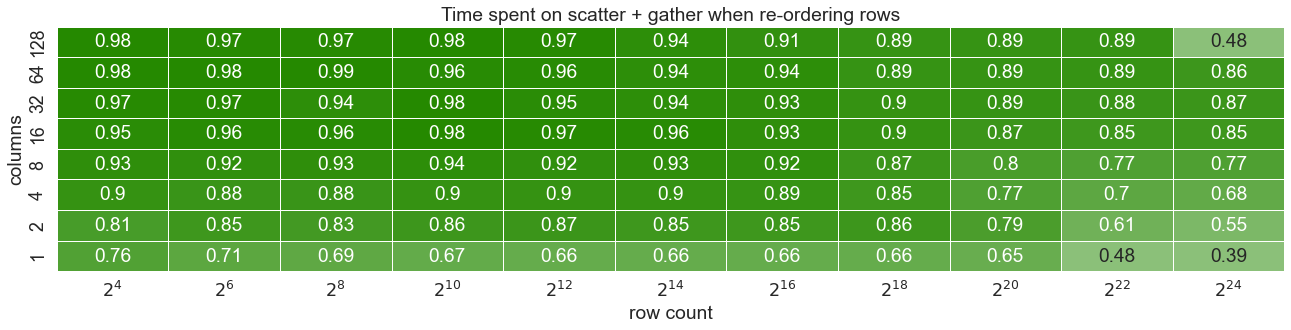

In [10]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(reorder_percentage_df.pivot('columns', 'row count', 'sg'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Time spent on scatter + gather when re-ordering rows')
plt.show()

# Comparator

In [11]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        row_id_width,
        col_width,
        median(total) as total,
        median(sort) as sort,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results_comparator.csv')
    group by
        category,
        count,
        columns,
        row_id_width,
        col_width
    order by
        count,
        columns,
        row_id_width,
        col_width,
        category
""")
comparator_df = con.fetchdf()
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,2.280400e+10
1,row_branched,1.749081e+10
2,row_branchless,1.591822e+10


In [12]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.total / r.total + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.total > r.total then c.total / r.total else -(r.total / c.total) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.total > r.total then 1 else -1 end as binary_speedup
    from
        comparator_df r,
        comparator_df c
    where
        r.category = 'row_branchless'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
comparator_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from comparator_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,-0.101136,0.0


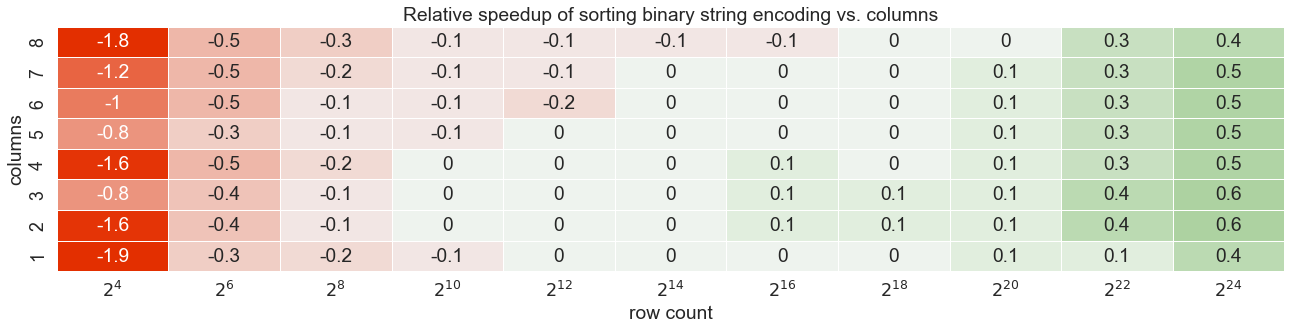

In [13]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(comparator_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of sorting binary string encoding vs. columns')
plt.show()

In [34]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.sort as "row sort",
        c.sort as "col sort",
        cast (case when c.sort > r.sort then c.sort / r.sort - 0.95 else -(r.sort / c.sort - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.reorder then 1 else -1 end as binary_speedup
    from
        comparator_df r,
        comparator_df c
    where
        r.category = 'row_branchless'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
comparator_only_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from comparator_only_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,0.2875,0.2


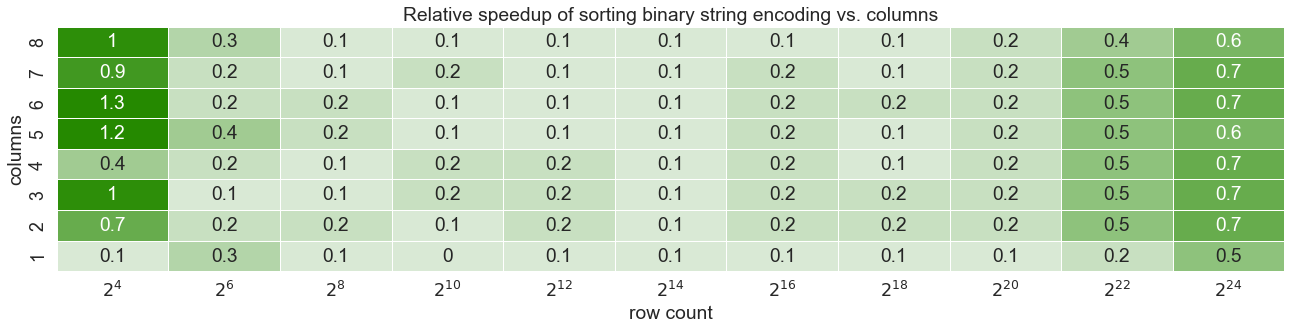

In [35]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(comparator_only_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of JUST sorting binary string encoding vs. columns (excl. scatter + gather)')
plt.show()

# Sort

In [14]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        row_id_width,
        col_width,
        median(total) as total,
        median(sort) as sort,
        median(scatter) as scatter,
        median(gather) as gather
    from
        read_csv_auto('results_sort.csv')
    group by
        category,
        count,
        columns,
        row_id_width,
        col_width
    order by
        count,
        columns,
        row_id_width,
        col_width,
        category
""")
sort_df = con.fetchdf()
con.execute("select category, sum(sort) from sort_df group by category")
con.fetchdf()

,category,sum(sort)
0,rad,1.898705e+10
1,std,1.446793e+10


In [15]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.sort as "row sort",
        c.sort as "col sort",
        cast (case when c.sort > r.sort then c.sort / r.sort - 0.95 else -(r.sort / c.sort - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        sort_df r,
        sort_df c
    where
        r.category = 'rad'
    and c.category = 'std'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
sort_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from sort_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,-2.625,-1.3


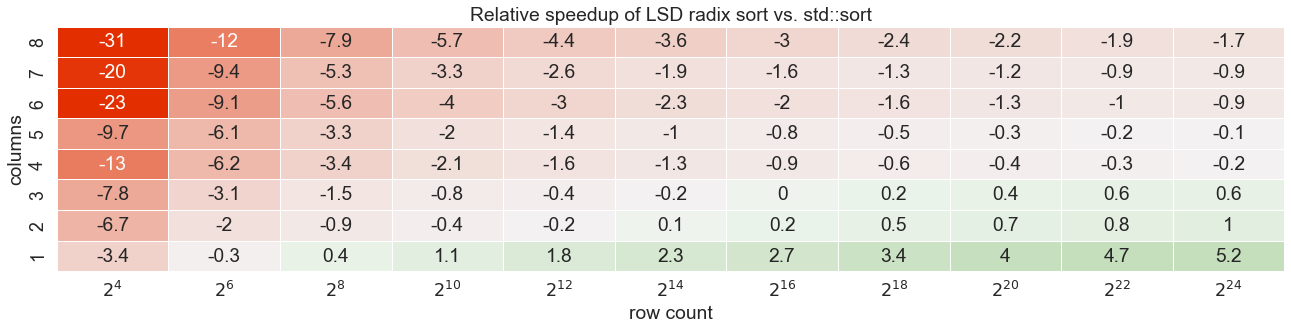

In [16]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(sort_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of LSD radix sort vs. std::sort')
plt.show()

# Merge

In [26]:
con = duckdb.connect()
con.execute("""
    select
        category,
        count,
        columns,
        col_width,
        median(total) as total
    from
        read_csv_auto('results_merge.csv')
    group by
        category,
        count,
        columns,
        col_width
    order by
        count,
        columns,
        col_width,
        category
""")
merge_df = con.fetchdf()
con.execute("select category, sum(total) from merge_df group by category")
con.fetchdf()

,category,sum(total)
0,col,5.333262e+10
1,row,6.463646e+09


In [27]:
con.execute("""
    select
        cast(log2(r.count) as int) as "row count",
        r.columns,
        r.col_width,
        r.total as "row total",
        c.total as "col total",
        cast (case when c.total > r.total then c.total / r.total - 0.95 else -(r.total / c.total - 0.95) end as decimal(10,1)) as speedup
        -- cast(c.sort / r.sort + 0.05 as decimal(10,1)) as speedup
        -- cast (case when c.sort > r.sort then c.sort / r.sort else -(r.sort / c.sort) end + 0.05 as decimal(10,1)) as speedup,
        -- case when c.sort > r.sort then 1 else -1 end as binary_speedup
    from
        merge_df r,
        merge_df c
    where
        r.category = 'row'
    and c.category = 'col'
    and r.count == c.count
    and r.columns == c.columns
    and r.col_width == c.col_width
    order by
        "row count" asc,
        columns asc
""")
merge_speedup_df = con.fetchdf()
con.execute("select avg(speedup), median(speedup) from merge_speedup_df")
con.fetchdf()

,avg(speedup),median(speedup)
0,8.690909,5.7


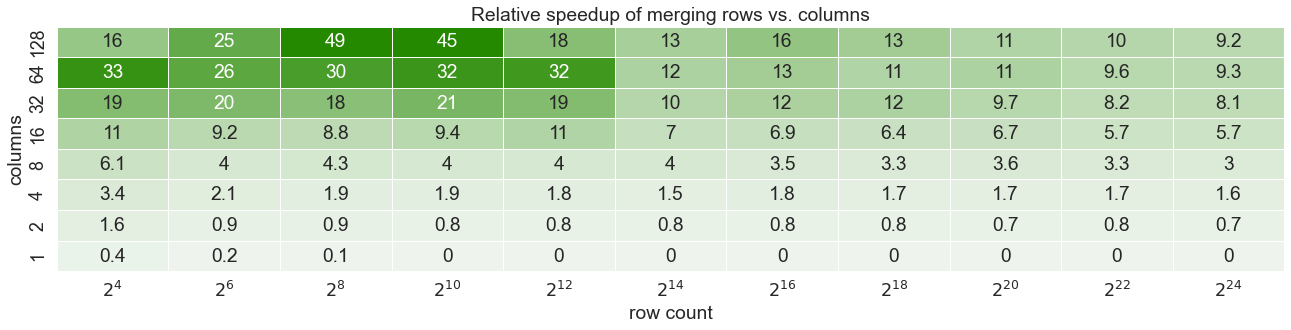

In [28]:
fig, ax = plt.subplots(figsize=(22,4.5))
g = sns.heatmap(merge_speedup_df.pivot('columns', 'row count', 'speedup'), linewidths=1, center=0, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
g.invert_yaxis()
labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.title('Relative speedup of merging rows vs. columns')
plt.show()